# Time Series Analysis and Forecasting

Basically, time series is sequential data that is indexed on timestamp.


![image.png](https://www.vertica.com/wp-content/uploads/2019/02/Timeseries.jpg)

## Basic Objectives of the Analysis

The basic objective usually is to determine a model that describes the pattern of the time series. Uses for such a model are:

- To describe the important features of the time series pattern.

- To explain how the past affects the future or how two time series can “interact”.

- To forecast future values of the series.

- To possibly serve as a control standard for a variable that measures the quality of product in some manufacturing situations.


Reference:

[PennState STAT510](https://online.stat.psu.edu/stat510/lesson/1/1.1)

[Medium](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)

[OTexts.com](https://otexts.com/fpp2/AR.html)

[Medium](https://towardsdatascience.com/a-blueprint-for-time-series-9f865609bfa2)


# Characteristics of Time Series

When we analyze or build a model for a timestamp dataset, there are some characteristic needs to be considered.

- Is there a __stationarity__ ?

![image.png](https://miro.medium.com/max/2400/1*xdblkZyg6YmmReAkZHUksw.png)

- Is there a __trend__, meaning that, on average, the measurements tend to increase (or decrease) over time?

![image,png](https://miro.medium.com/max/1276/1*xYwv3xjv1sdq4rPUlzRarA.jpeg)

- Is there __seasonality__, meaning that there is a regularly repeating pattern of highs and lows related to calendar time such as seasons, quarters, months, days of the week, and so on?

![image.png](https://www.researchgate.net/profile/Grace-Rumantir/publication/2797556/figure/fig6/AS:279556704489480@1443662920465/An-example-of-a-time-series-with-a-long-term-trend-a-seasonal-e-ect-with-superimposed.png)

- Are there __outliers?__ In regression, outliers are far away from your line. With time series data, your outliers are far away from your other data.

- Is there a __long-run cycle or period__ unrelated to seasonality factors?

- Is there constant variance over time, or is the variance non-constant?

- Are there any abrupt changes to either the level of the series or the variance?

In [37]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

# Dataset

Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.

__Period of Record:__ March 1973 - December 2021

This dataset includes a monthly observation of atmospheric carbon dioxide (or CO2) concentrations from the US.


In [38]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_csv("natural_gas_emission.csv", parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts.head(15)
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 584 entries, 1973-01-01 to 2021-08-01
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    584 non-null    int64  
 1   MSN           584 non-null    object 
 2   Value         584 non-null    float64
 3   Column_Order  584 non-null    int64  
 4   Description   584 non-null    object 
 5   Unit          584 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 31.9+ KB


In [39]:
ts.drop(['Unnamed: 0','MSN','Column_Order','Unit','Description'], axis = 1, inplace = True)

In [40]:
ts.info()
y=ts

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 584 entries, 1973-01-01 to 2021-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   584 non-null    float64
dtypes: float64(1)
memory usage: 9.1 KB


In [41]:
y.index.sort_values()
y = y['Value'].resample('MS').mean()

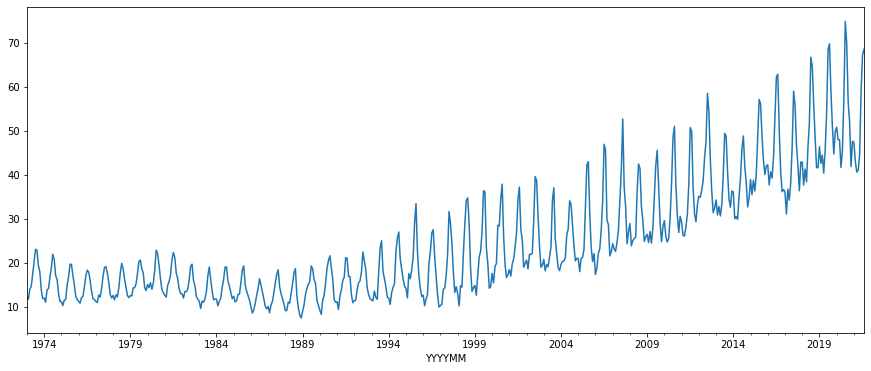

In [42]:
y = y.fillna(y.bfill())
y.head()

y.plot(figsize=(15, 6))
plt.show()

In [43]:
# Train set.
train = y[:'2016-12-01']
#len(train)  # 528 months

# Test set.
test = y['2017-01-01':]
#len(test)  # 56 moths

In [44]:
#train = y[:len(y)-12]
#test = y[len(y)-12:]

In [45]:
#Storing test data 
df1 = pd.DataFrame(data=test.index, columns=['YYYYMM'])
df2 = pd.DataFrame(data=test.values, columns=['Value'])
df = pd.merge(df1, df2, left_index=True, right_index=True)
df

,YYYYMM,Value
0,2017-01-01,36.054
1,2017-02-01,31.075
2,2017-03-01,36.718
3,2017-04-01,34.215
4,2017-05-01,38.166
5,2017-06-01,46.386
6,2017-07-01,59.004
7,2017-08-01,55.747
8,2017-09-01,46.821
9,2017-10-01,42.115


# Dickey-Fuller Test

We will use Augmented Dickey-Fuller test to test our null hypothesis that our series is not stationary. If we get a significant p value, we will reject our null hypothesis and establish that our series is stationary. On the contrary, if we fail to reject our null hypothesis, we will difference the series and run the test again.

In [46]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")


is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.995)


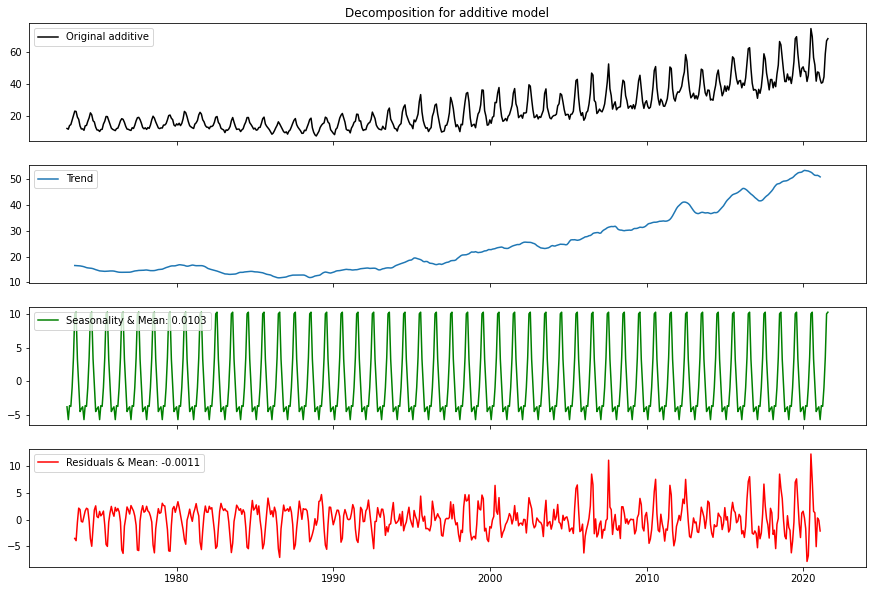

Result: Non-Stationary (H0: non-stationary, p-value: 0.995)


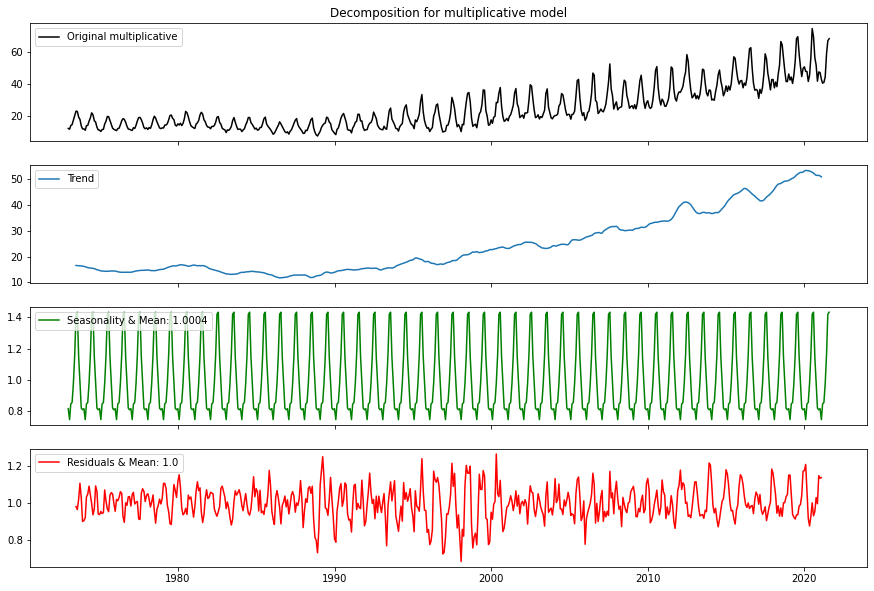

Result: Non-Stationary (H0: non-stationary, p-value: 0.995)


In [47]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)
        
for model in ["additive", "multiplicative"]:
    ts_decompose(y, model, stationary=True)

# Modelling the Time Series

There are several ways to model a time seris to make predictions.

We will mention the topics as below:

- Moving Average

- Weighted Average

- Exponential Smoothing Methods

     -Single Exponential Smoothing (It contains stationarity)
     
     -Double Exponential Smoothing (It contains Level + Trend)
     
     -Triple Exponential Smoothing Holt-Witers (It contains Level + Tred + Seasonality)
     
- ARIMA Models

# 1) Moving Average

The moving average model is probably the most naive approach to time series modelling. This model simply states that the next observation is the mean of all past observations.

Although simple, this model might be surprisingly good and it represents a good starting point.

Otherwise, the moving average can be used to identify interesting trends in the data. We can define a window to apply the moving average model to smooth the time series, and highlight different trends.

![image.png](https://miro.medium.com/max/2400/1*WZOyzZewXwKOhJBbN82kfg.png)

# 2) Single Exponential Smoothing

![image.png](https://miro.medium.com/max/2400/1*d8UsN4g3URJAaaEzD-zyZA.png)

    Makes predictions by exponentially correcting (recursive).
    
    The future is more related to the recent past and using the assumption, the effects of the past are weighted.
    
    Estimates are made by exponentially weighting past actual values and past estimated values.

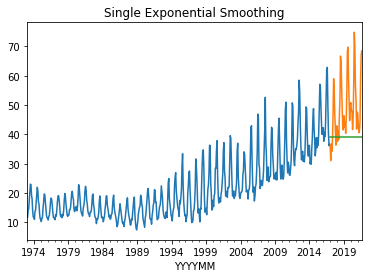

In [48]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

y_pred = ses_model.forecast(56)

mean_absolute_error(test, y_pred)

train.plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

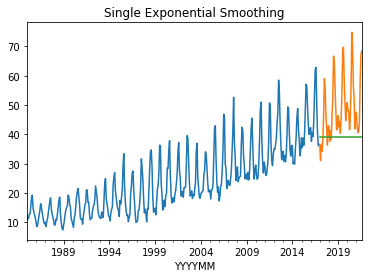

In [49]:
train["1985":].plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

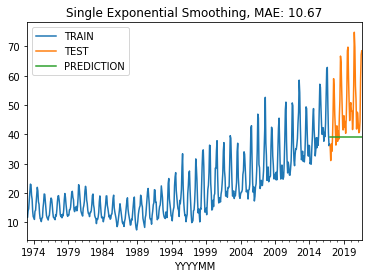

In [50]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1973":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()


plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [51]:
############################
# Hyperparameter Optimization
############################


def ses_optimizer(train, alphas, step=56):
    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.8, 1, 0.01)
ses_optimizer(train, alphas)

best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.8 mae: 12.5271
alpha: 0.81 mae: 12.549
alpha: 0.82 mae: 12.5689
alpha: 0.83 mae: 12.5868
alpha: 0.84 mae: 12.603
alpha: 0.85 mae: 12.6179
alpha: 0.86 mae: 12.6311
alpha: 0.87 mae: 12.6425
alpha: 0.88 mae: 12.6524
alpha: 0.89 mae: 12.6607
alpha: 0.9 mae: 12.6676
alpha: 0.91 mae: 12.6731
alpha: 0.92 mae: 12.6774
alpha: 0.93 mae: 12.6804
alpha: 0.94 mae: 12.6822
alpha: 0.95 mae: 12.6829
alpha: 0.96 mae: 12.6826
alpha: 0.97 mae: 12.6813
alpha: 0.98 mae: 12.6791
alpha: 0.99 mae: 12.676
best_alpha: 0.8 best_mae: 12.5271
alpha: 0.8 mae: 12.5271
alpha: 0.81 mae: 12.549
alpha: 0.82 mae: 12.5689
alpha: 0.83 mae: 12.5868
alpha: 0.84 mae: 12.603
alpha: 0.85 mae: 12.6179
alpha: 0.86 mae: 12.6311
alpha: 0.87 mae: 12.6425
alpha: 0.88 mae: 12.6524
alpha: 0.89 mae: 12.6607
alpha: 0.9 mae: 12.6676
alpha: 0.91 mae: 12.6731
alpha: 0.92 mae: 12.6774
alpha: 0.93 mae: 12.6804
alpha: 0.94 mae: 12.6822
alpha: 0.95 mae: 12.6829
alpha: 0.96 mae: 12.6826
alpha: 0.97 mae: 12.6813
alpha: 0.98 mae: 12.6791


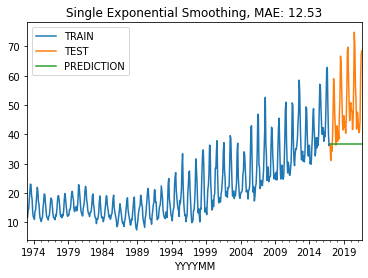

12.527142510274228

In [52]:
############################
# Final SES Model
############################

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(56)

plot_co2(train, test, y_pred, "Single Exponential Smoothing")
mean_absolute_error(test, y_pred)

In [53]:
df['SES'] = y_pred.values

In [55]:
ses_rmse_error = rmse(test, y_pred)
ses_mse_error = ses_rmse_error**2
from sklearn.metrics import mean_absolute_error
ses_mae = mean_absolute_error(test, y_pred)
ses_mape = (np.mean(np.abs(test-y_pred)/test)*100)
print(f'MAE: {ses_mae}')
print(f'MSE Error: {ses_mse_error}\nRMSE Error: {ses_rmse_error}')
print(f"MAPE: {ses_mape}" )

NameError: name 'rmse' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error

sees_rmse_error = np.sqrt(mean_squared_error(test,y_pred))
sees_mse_error = sees_rmse_error**2
from sklearn.metrics import mean_absolute_error
ses_mae = mean_absolute_error(test, y_pred)
ses_mape = (np.mean(np.abs(test-y_pred)/test)*100)
print(f'MAE: {ses_mae}')
print(f'MSE Error: {sees_mse_error}\nRMSE Error: {sees_rmse_error}')
print(f"MAPE: {ses_mape}" )

# 3) Double Exponential Smoothing

![image.png](https://miro.medium.com/max/2400/1*Ng9wsOnjHu8FAse6ba2mwg.png)

    Makes predictions by exponentially correcting based on trend effect (recursive).
    
    DES = Level(SSE) + Trend
    
    The main approach is same like SSE. Additionally, trend effect is considered
    
    It is used for univariate time series with trend and no seasonality.


In [ ]:
##################################################
# Double Exponential Smoothing (DES)
##################################################

# DES: Level (SES) + Trend

des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5,
                                                         smoothing_trend=0.5)

y_pred = des_model.forecast(56)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

des_model.params

In [ ]:
############################
# Hyperparameter Optimization
############################


def des_optimizer(train, alphas, betas, step=56):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha,
                                                                     smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)


In [ ]:
############################
# Final DES Model
############################

final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

y_pred = final_des_model.forecast(56)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

In [ ]:
df['DES']=y_pred.values
des_rmse_error = rmse(test, y_pred)
des_mse_error = des_rmse_error**2
from sklearn.metrics import mean_absolute_error
des_mae = mean_absolute_error(test, y_pred)
des_mape = (np.mean(np.abs(test-y_pred)/test)*100)
print(f'MAE: {des_mae}')
print(f'MSE Error: {des_mse_error}\nRMSE Error: {des_rmse_error}')
print(f"MAPE: {des_mape}" )

# 4) Triple Exponential Smoothing Holt-Witers

![image.png](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Faimlzone.com%2Fwp-content%2Fuploads%2F2020%2F01%2Fimage-8.png&f=1&nofb=1)

        Level(SSE) + Trend + Seasonality
        
        State of art method for smoothinng methods
        
        This method predicts dynamically using level, trend and seasonality.
        
        

In [ ]:
##################################################
# Triple Exponentıal Smoothing (Holt-Winters)
##################################################


# TES = SES + DES + Mevsimsellik

tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)


y_pred = tes_model.forecast(56)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

In [ ]:
############################
# Hyperparameter Optimization
############################

def tes_optimizer(train, abg, step=56):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae


alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))


best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)



In [ ]:
############################
# Final TES Model
############################

final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = final_tes_model.forecast(56)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

In [ ]:
from sklearn.metrics import mean_squared_error
print('Test Root Mean Squared Error for ',np.sqrt(mean_squared_error(y_pred,test)))
print("Test MAPE", (np.mean(np.abs(test-y_pred)/test)*100))

In [ ]:
df['TES']=y_pred.values
tes_rmse_error = rmse(test, y_pred)
tes_mse_error = tes_rmse_error**2
from sklearn.metrics import mean_absolute_error
tes_mae = mean_absolute_error(test, y_pred)
tes_mape = (np.mean(np.abs(test-y_pred)/test)*100)
print(f'MAE: {tes_mae}')
print(f'MSE Error: {tes_mse_error}\nRMSE Error: {tes_rmse_error}')
print(f"MAPE: {tes_mape}" )

# Autocorrelation (ACF)

Informally, autocorrelation is the similarity between observations as a function of the time lag between them.

![image.png](https://miro.medium.com/max/700/1*F5wTJgw8dpteJssJVGXPcg.png)

Above is an example of an autocorrelation plot. Looking closely, you realize that the first value and the 24th value have a high autocorrelation. Similarly, the 12th and 36th observations are highly correlated. This means that we will find a very similar value at every 24 unit of time.
Notice how the plot looks like sinusoidal function. This is a hint for seasonality, and you can find its value by finding the period in the plot above, which would give 24h.

Variance is : $Var(x_t)= \sigma^2_w(1+\theta^2_1)$

Autocorrelation function (ACF) is: $ \rho_1 = \dfrac{\theta_1}{1+\theta^2_1}, \text{ and } \rho_h = 0 \text{ for } h \ge 2 $

In [ ]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y, lags=31)
pyplot.show()

# 1) AR(p): Autoregression

This is basically a regression of the time series onto itself. Here, we assume that the current value depends on its previous values with some lag. It takes a parameter p which represents the maximum lag. To find it, we look at the partial autocorrelation plot and identify the lag after which most lags are not significant.

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable.

Thus, an autoregressive model of order p can be written as;

>$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}, $

where $\varepsilon_t$ s white noise. This is like a multiple regression but with lagged values of yt as predictors.


> Estimation is made by a linear combination of observations from previous time steps.

> Suitable for univariate time series without trend and seasonality

# 2) MA(q): Moving Average

A moving average term in a time series model is a past error (multiplied by a coefficient).

>The 1st order moving average model, denoted by MA(1) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}$

>The 2nd order moving average model, denoted by MA(2) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}+\theta_2w_{t-2}$

>The qth order moving average model, denoted by MA(q) is:

> $x_t = \mu + w_t +\theta_1w_{t-1}+\theta_2w_{t-2}+\dots + \theta_qw_{t-q}$


## ACF for General MA(q) Models

A property of MA(q) models in general is that there are nonzero autocorrelations for the first q lags and autocorrelations = 0 for all lags > q.

For a time series;

> $\rho_h = \dfrac{\text{Covariance for lag h}}{\text{Variance}}$

Apply this result to get the ACF

## Partial Autocorrelation Function (PACF)

In general, a partial correlation is a conditional correlation. It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables. For instance, consider a regression context in which y is the response variable and x1, x2 and x3 are predictor variables. The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

In regression, this partial correlation could be found by correlating the residuals from two different regressions:

>Regression in which we predict y from x1 and x2

>regression in which we predict x3 from x1 and x2, Basically we correlate the parts of y and x3 that are not predicted by x1 and x2


$\dfrac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

# Some Useful Facts About PACF and ACF Patterns

__Identification of an AR model is often best done with the PACF.__

> For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

__Identification of an MA model is often best done with the ACF rather than the PACF__

>For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

# ARMA Model(p,q) = AR(p) + MA(q)

ARIMA models, also called Box-Jenkins models, are models that may possibly include autoregressive terms, moving average terms, and differencing operations. Various abbreviations are used:

>When a model only involves autoregressive terms it may be referred to as an AR model. When a model only involves moving average terms, it may be referred to as an MA model.

>When no differencing is involved, the abbreviation ARMA may be used.

__Summary:__

>AutoRegressive Moving Average(ARIMA) combines AR and MA methods

>It predicts with a linear combination of past values ​​and past errors.

> Suitable for univariate time series without trend and seasonality

In [ ]:
##################################################
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)
##################################################


arima_model = ARIMA(train, order=(1, 1, 1)).fit(disp=0)
arima_model.summary()

y_pred = arima_model.forecast(56)[0]
y_pred = pd.Series(y_pred, index=test.index)


plot_co2(train, test, y_pred, "ARIMA")

arima_model.plot_predict(dynamic=False)
plt.show()

In [ ]:
from statsmodels.tools.eval_measures import rmse
arima_rmse_error = rmse(test, y_pred)
arima_mse_error = arima_rmse_error**2
mean_value = y.mean()
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

LR_MAPE= MAPE(test,y_pred)
print("MAPE: ",LR_MAPE)

In [ ]:
from sklearn.metrics import mean_squared_error
print('Test Root Mean Squared Error for ',np.sqrt(mean_squared_error(y_pred,test)))
print("Test MAPE", (np.mean(np.abs(test-y_pred)/test)*100))

In [ ]:
#df['TES']=y_pred.values
barima_rmse_error = rmse(test, y_pred)
barima_mse_error = barima_rmse_error**2
from sklearn.metrics import mean_absolute_error
barima_mae = mean_absolute_error(test, y_pred)
barima_mape = (np.mean(np.abs(test-y_pred)/test)*100)
print(f'MAE: {barima_mae}')
print(f'MSE Error: {barima_mse_error}\nRMSE Error: {barima_rmse_error}')
print(f"MAPE: {barima_mape}" )

In [ ]:
############################
# Hyperparameter Optimization (Model Derecelerini Belirleme)
############################

#1. Determining Model Grade Based on AIC Statistics
#2. Determining Model Grade Based on ACF & PACF Charts

############################
# Determining Model Grade Based on AIC & BIC Statistics
############################

# producing p and q combinations
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params


best_params_aic = arima_optimizer_aic(train, pdq)


In [ ]:
############################
# Final Model
############################

arima_model = ARIMA(train, best_params_aic).fit(disp=0)
y_pred = arima_model.forecast(56)[0]
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "ARIMA")

In [ ]:
df['Arima']=y_pred.values
arima_rmse_error = rmse(test, y_pred)
arima_mse_error = arima_rmse_error**2
from sklearn.metrics import mean_absolute_error
arima_mae = mean_absolute_error(test, y_pred)
arima_mape = (np.mean(np.abs(test-y_pred)/test)*100)
print(f'MAE: {arima_mae}')
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')
print(f"MAPE: {arima_mape}" )

In [ ]:
############################
# Determining Model Grade Based on ACF & PACF Charts
############################

def acf_pacf(y, lags=30):
    plt.figure(figsize=(12, 7))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)

    # Stationarity test (HO: Series is not Stationary. H1: Series is Stationary.)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()

acf_pacf(y)

In [ ]:
######################
# Determining Model Grade with ACF and PACF Chart
######################


# IF ACF width "DECREASE" relative to the delays and PACF "CUT" after the p delay means it's an AR(p) pattern.

# If the ACF width q "CUT" after the delay and the PACF width "DECREASE" according to the delays, it means it's a MA(q) pattern.

# If the widths of ACF and PACF are decreasing according to the delays, it means it is an ARMA model.
df_diff = y.diff()
df_diff.dropna(inplace=True)

acf_pacf(df_diff)

# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

After, we add the order of integration I(d). The parameter d represents the number of differences required to make the series stationary.
Finally, we add the final component: seasonality S(P, D, Q, s), where s is simply the season’s length. Furthermore, this component requires the parameters P and Q which are the same as p and q, but for the seasonal component. Finally, D is the order of seasonal integration representing the number of differences required to remove seasonality from the series.
Combining all, we get the SARIMA(p, d, q)(P, D, Q, s) model.
The main takeaway is: before modelling with SARIMA, we must apply transformations to our time series to remove seasonality and any non-stationary behaviors.


__Summary__:

>ARIMA + seasonality

>It can be used in univariate series with trend and/or seasonality.

>The p,d,q parameters are the parameters from the ARIMA model. They are trend elements and ARIMA can model the trend.

>p: Actual value delay number (autoregressive degree)

>d: Number of difference operations (degree of difference)

>q: Error delay number (Moving average degree)

P,D,Q seasonal lag numbers.

m is the number of time steps for a single seasonal period. Expresses the structure of seasonality.

# Model Usage for Different Scenario

>Stationarity: SES, AR, MA, ARMA

>Trend : DES, ARIMA, SARIMA

>Trend + Seasonality: TES + SARIMA

In [ ]:
##################################################
# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)
##################################################



model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))
sarima_model = model.fit(disp=0)

y_pred_test = sarima_model.get_forecast(steps=56)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

In [ ]:
############################
# Hyperparameter Optimization
############################


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order


best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)



In [ ]:
############################
# Final Model
############################

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=56)

# MAE
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

In [ ]:
##################################################
# Examining the Statistical Outputs of the Model
##################################################
sarima_final_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
df['SArima']=y_pred.values
sarima_rmse_error = rmse(test, y_pred)
sarima_mse_error = sarima_rmse_error**2
from sklearn.metrics import mean_absolute_error
sarima_mae = mean_absolute_error(test, y_pred)
sarima_mape = (np.mean(np.abs(test-y_pred)/test)*100)
print(f'MAE: {sarima_mae}')
print(f'MSE Error: {sarima_mse_error}\nRMSE Error: {sarima_rmse_error}')
print(f"MAPE: {sarima_mape}" )

In [ ]:
rmse_errors = [ses_rmse_error, des_rmse_error, tes_rmse_error, arima_rmse_error, sarima_rmse_error]
mse_errors = [ses_mse_error,des_mse_error, tes_mse_error, arima_mse_error, sarima_mse_error]
mae = [ses_mae,des_mae,tes_mae, arima_mae, sarima_mae]
mape = [ses_mape,des_mape,tes_mape, arima_mape,sarima_mape]
errors = pd.DataFrame({"Models" : ["SES", "SES", "TES", "ARIMA" , "SARIMA"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors, "MAPE" : mape, "MAE" : mae })

In [ ]:
print(f"Mean: {df['Value'].mean()}")
errors

In [ ]:
df

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(df.index, df["DES"], linestyle="-")
plt.plot_date(df.index, df["TES"], linestyle="-.")

plt.plot_date(df.index, df["Arima"], linestyle="--")
plt.plot_date(df.index, df["SArima"], linestyle=":")
plt.legend()
plt.show()